In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [37]:
# Load the dataset info CSV
df = pd.read_csv("results/dataset_info.csv")

# Extract dataset group from the 'dataset' column prefix
def extract_group(name):
    if name.startswith("autogluon/chronos"):
        return "Chronos"
    elif name.startswith("Salesforce/lotsa"):
        return "Lotsa"
    elif name.startswith("ett"):
        return "ETT"
    else:
        return "other"

df["group"] = df["dataset"].apply(extract_group)

In [38]:
# Set seaborn style
plt.rcParams["figure.figsize"] = (15, 6)

In [39]:
GROUP_PALETTE = {
    "Lotsa": "lawngreen",
    "Chronos": "lightskyblue",
    "ETT": "deeppink",
    "other": "gray"
}

In [40]:
# Compute statistics
pivot_table = df.groupby("group").agg({
    "ts_len": ["mean", "std", "min", "max"],
    "num_variates": ["mean", "std", "min", "max"],
    "item_id": "count"
})

# Rename columns for clarity
pivot_table.columns = ['_'.join(col).strip() for col in pivot_table.columns.values]
pivot_table = pivot_table.rename(columns={"item_id_count": "num_series"})

# Round for better display
pivot_table = pivot_table.round(4)

pivot_table

,ts_len_mean,ts_len_std,ts_len_min,ts_len_max,num_variates_mean,num_variates_std,num_variates_min,num_variates_max,num_series
group,,,,,,,,,
Chronos,1.0000,0.000,1,1,23109.1546,40457.5376,156,140256,3934
ETT,1.0000,0.000,1,1,21600.0000,14964.9190,8640,34560,4
Lotsa,2093.3613,9837.617,1,614880,7623.5184,25328.5393,2,527040,74104


C:\Users\giuli\AppData\Local\Temp\ipykernel_6768\2367096868.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="group", palette=GROUP_PALETTE)


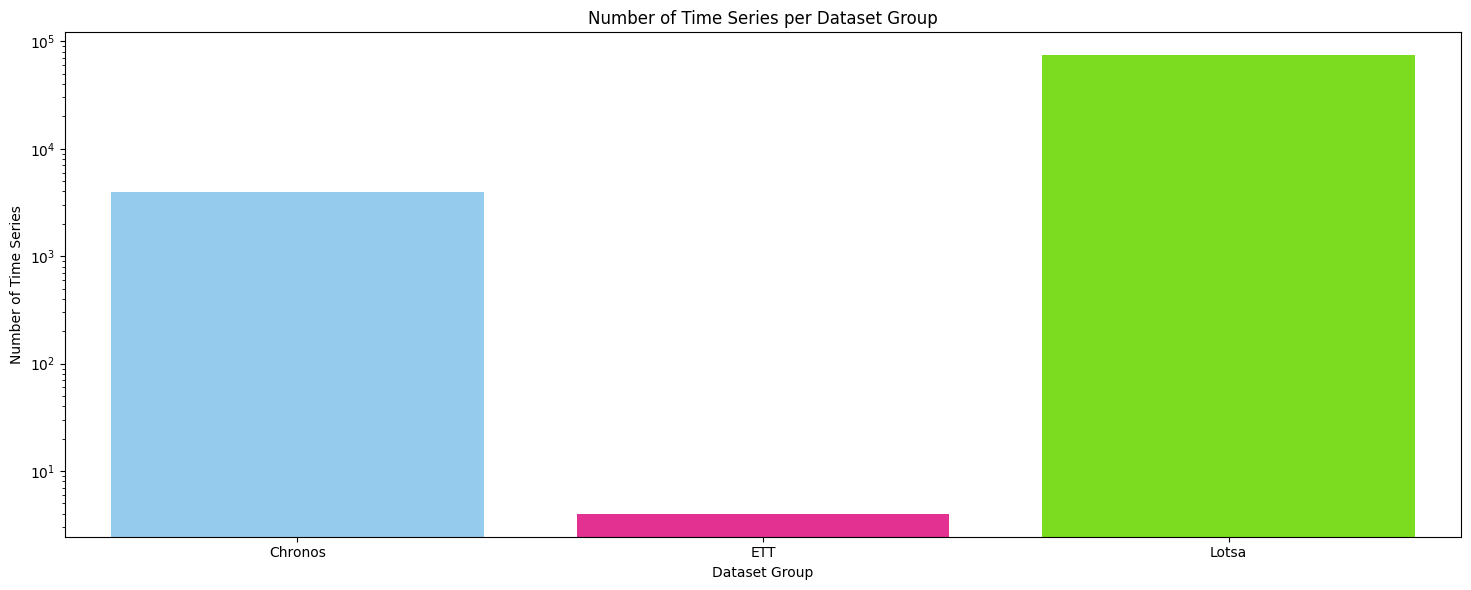

In [41]:
# === 1. Barplot: Number of time series per dataset group ===
plt.figure()
sns.countplot(data=df, x="group", palette=GROUP_PALETTE)
plt.title("Number of Time Series per Dataset Group")
plt.xlabel("Dataset Group")
plt.ylabel("Number of Time Series")
plt.tight_layout()
plt.yscale("log")
plt.savefig("figures/plot_num_series_per_dataset.png")
plt.show()

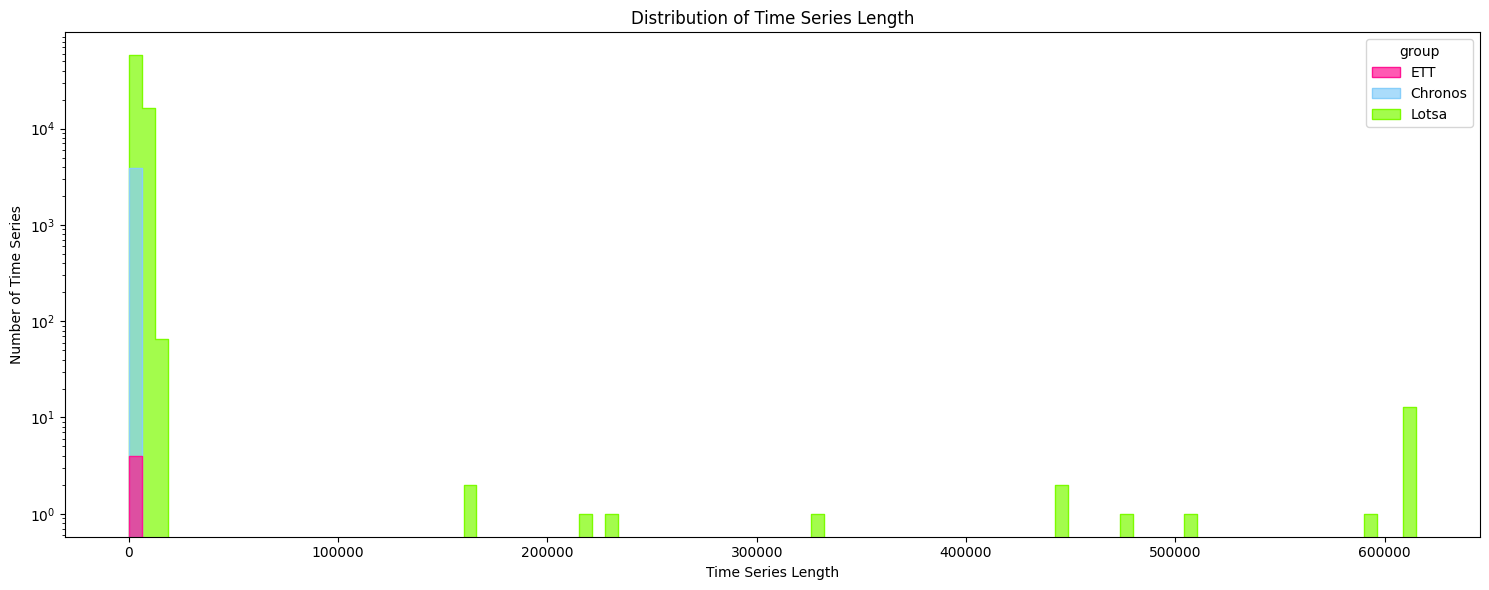

In [42]:
# === 2. Histogram: Time series length (ts_len) distribution ===
plt.figure()
sns.histplot(
    data=df, x="ts_len", hue="group", element="step", stat="count",
    common_norm=False, bins=100, palette=GROUP_PALETTE, alpha=0.7,
    hue_order=["ETT", "Chronos", "Lotsa"])
plt.title("Distribution of Time Series Length")
plt.xlabel("Time Series Length")
plt.ylabel("Number of Time Series")
plt.yscale("log")
plt.tight_layout()
plt.savefig("figures/plot_ts_len_distribution.png")
plt.show()

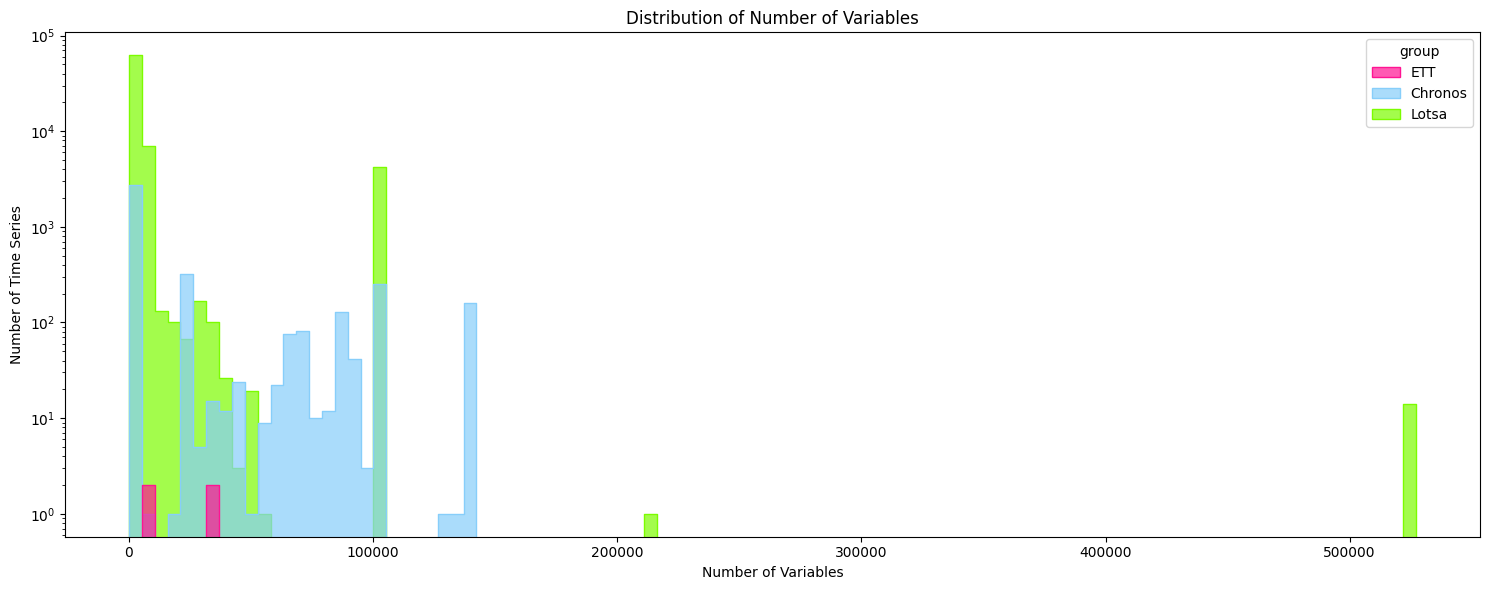

In [43]:
# === 3. Histogram: Number of variables per time series ===
plt.figure()
sns.histplot(
    data=df, x="num_variates", hue="group", element="step", stat="count",
    common_norm=False, bins=100, palette=GROUP_PALETTE, alpha=0.7,
    hue_order=["ETT", "Chronos", "Lotsa"])
plt.title("Distribution of Number of Variables")
plt.xlabel("Number of Variables")
plt.ylabel("Number of Time Series")
plt.yscale("log")
plt.tight_layout()
plt.savefig("figures/plot_num_variates_distribution.png")
plt.show()

In [44]:
df[df["group"]=="Chronos"]["num_variates"].unique(), df[df["group"]=="ETT"]["num_variates"].unique()

(array([105216,  46984,  55238,  96628,  57735,  74439,  86534,  43632,
         45538,  67161,  33792,  30432,  31008, 140256,  87743,  28160,
         70080,  76354, 104575,  31776, 135218,  46327,  88608,  64512,
         97536,  86304,  16032,  36192,  28992,  85920,  53664,  44308,
         53376,  75264, 131040,  38208,  37248,  83232,  46944,  82700,
         33504, 102235, 104437,  88806,  75960,  63074,   9673,  59647,
         88512,  57732,  90152,  90297,  83238,  88085,   2197,  84418,
         90185, 102240,  88499,  59937,  90298,  90294,  90315,  90299,
         90301,  88092,  90273,  88508, 104438,  90292,  90319,  90295,
         89175,  89174,  90316,  86961, 102238,  86858,  89771,  89169,
         86722,  87006,  87361, 102233,  89172,  89723,  87444,  89168,
         86962,  86856,  87338, 102136,  89657,  87418,  86965,  83270,
         89176,   1526,  86545, 104443,  82598,  87359,  86899,  86808,
         89171,  88498,  88496,  85881,  86242,  86288,  86290, 

In [45]:
FREQ_MAP = {
    "T": "1 min",
    "5T": "5 min",
    "10T": "10 min",
    "15T": "15 min",
    "30T": "30 min",
    "H": "1 hour",
    "1H": "1 hour",
    "6H": "6 hours",
    "D": "daily",
    "1D": "daily",
    "W": "weekly",
    "1W": "weekly",
    "W-SUN": "weekly",
    "M": "monthly",
    "MS": "monthly",      # Month Start
    "Q-DEC": "quarterly", # Quarterly ending in December
    "A-DEC": "yearly",    # Annual frequency ending in December
}

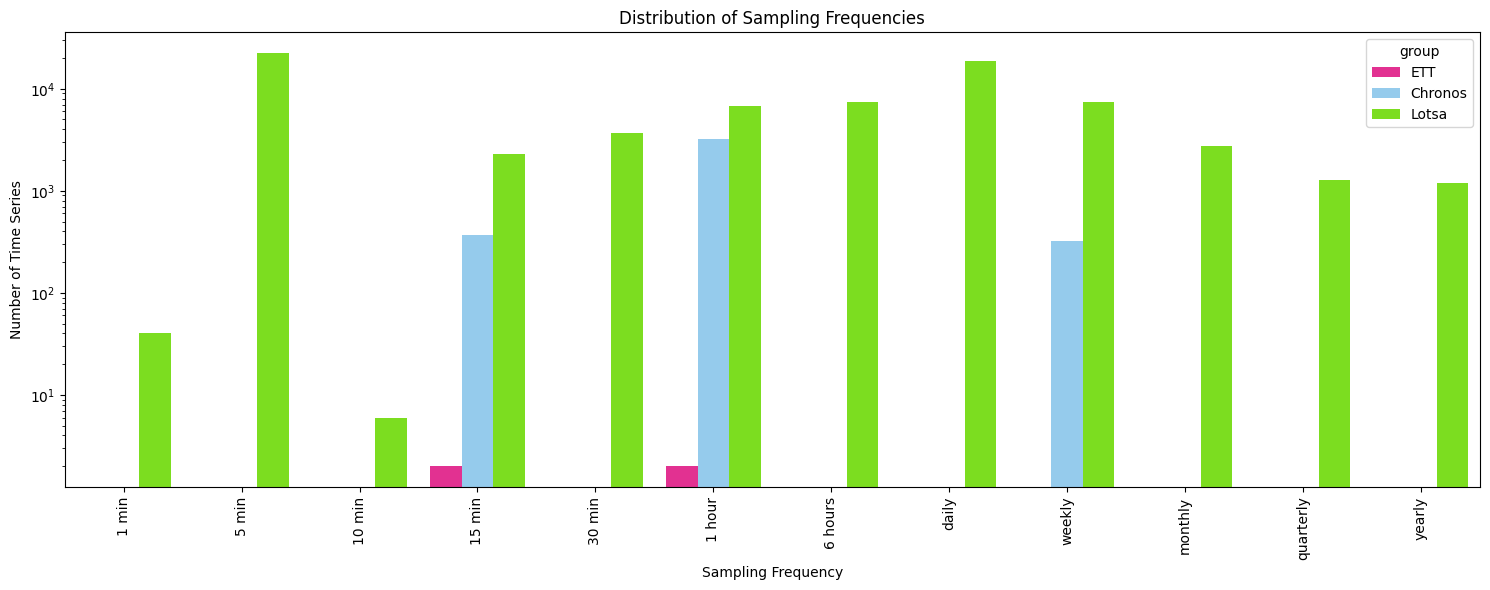

In [46]:
# === 4. Barplot: Frequency distribution per dataset group ===

# Map raw frequencies to human-readable labels
df["freq_label"] = df["freq"].map(FREQ_MAP).fillna("other")

# Order of the frequencies for plotting
FREQ_ORDER = [
    "1 min", "5 min", "10 min", "15 min", "30 min",
    "1 hour", "6 hours",
    "daily", "weekly", "monthly", "quarterly", "yearly"
]

# Plot the frequency distribution grouped by dataset group
plt.figure()
sns.countplot(
    data=df, x="freq_label", hue="group",
    order=FREQ_ORDER, palette=GROUP_PALETTE,
    hue_order=["ETT", "Chronos", "Lotsa"])
plt.title("Distribution of Sampling Frequencies")
plt.xlabel("Sampling Frequency")
plt.ylabel("Number of Time Series")
plt.xticks(rotation=90)
plt.yscale("log")
plt.tight_layout()
plt.savefig("figures/plot_freq_distribution.png")
plt.show()

### Splitted Dataset

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [48]:
# Load the dataset info CSV
df = pd.read_csv("results/dataset_splitted_info.csv")

# Extract dataset group from the 'dataset' column prefix
def extract_group(name):
    if name.startswith("autogluon/chronos"):
        return "Chronos"
    elif name.startswith("Salesforce/lotsa"):
        return "Lotsa"
    elif name.startswith("ett"):
        return "ETT"
    else:
        return "other"

df["group"] = df["dataset"].apply(extract_group)

In [49]:
# Set seaborn style
plt.rcParams["figure.figsize"] = (15, 6)

In [50]:
GROUP_PALETTE = {
    "Lotsa": "lawngreen",
    "Chronos": "lightskyblue",
    "ETT": "deeppink",
    "other": "gray"
}

In [51]:
# Compute statistics
pivot_table = df.groupby("group").agg({
    "ts_len": ["mean", "std", "min", "max"],
    "num_variates": ["mean", "std", "min", "max"],
    "item_id": "count"
})

# Rename columns for clarity
pivot_table.columns = ['_'.join(col).strip() for col in pivot_table.columns.values]
pivot_table = pivot_table.rename(columns={"item_id_count": "num_series"})

# Round for better display
pivot_table = pivot_table.round(4)

pivot_table

,ts_len_mean,ts_len_std,ts_len_min,ts_len_max,num_variates_mean,num_variates_std,num_variates_min,num_variates_max,num_series
group,,,,,,,,,
Chronos,1.0000,0.0000,1,1,23109.1546,40457.5376,156,140256,3934
ETT,1.0000,0.0000,1,1,21600.0000,14964.9190,8640,34560,4
Lotsa,129.5878,539.4578,1,6863,8480.9177,21051.2805,2,527040,105040


C:\Users\giuli\AppData\Local\Temp\ipykernel_6768\3232055286.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="group", palette=GROUP_PALETTE)


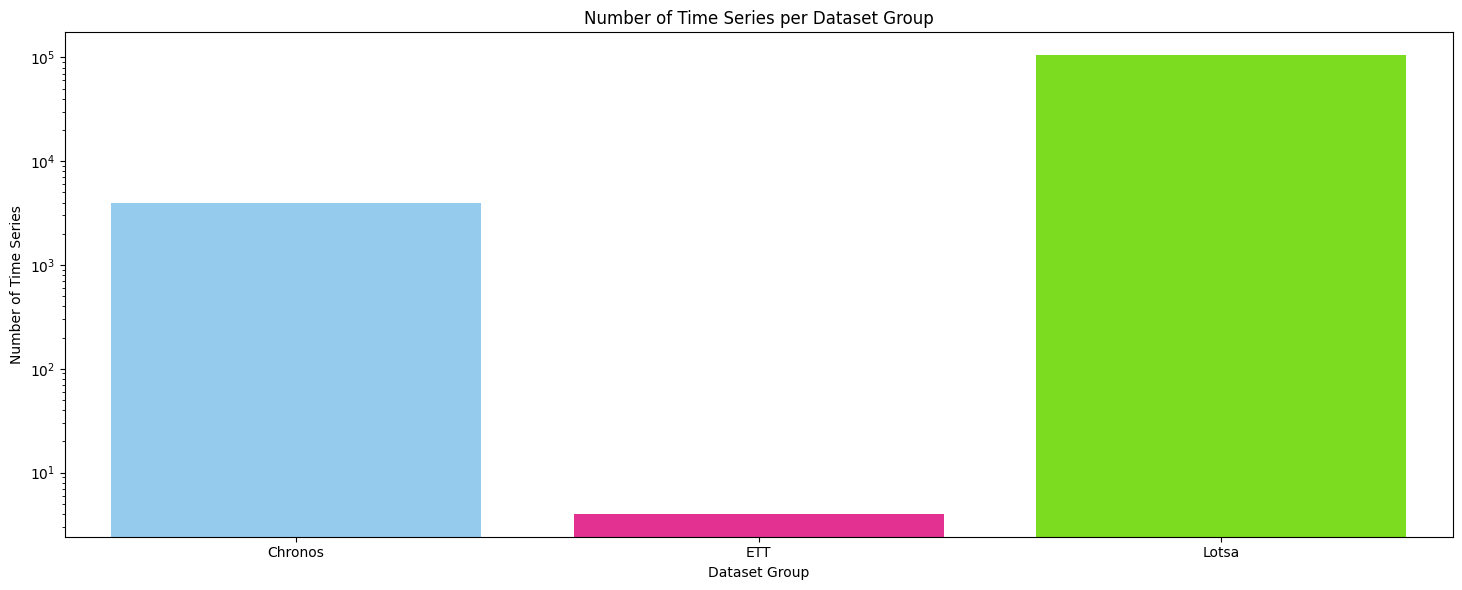

In [52]:
# === 1. Barplot: Number of time series per dataset group ===
plt.figure()
sns.countplot(data=df, x="group", palette=GROUP_PALETTE)
plt.title("Number of Time Series per Dataset Group")
plt.xlabel("Dataset Group")
plt.ylabel("Number of Time Series")
plt.tight_layout()
plt.yscale("log")
plt.savefig("figures/plot_num_series_per_dataset_final.png")
plt.show()

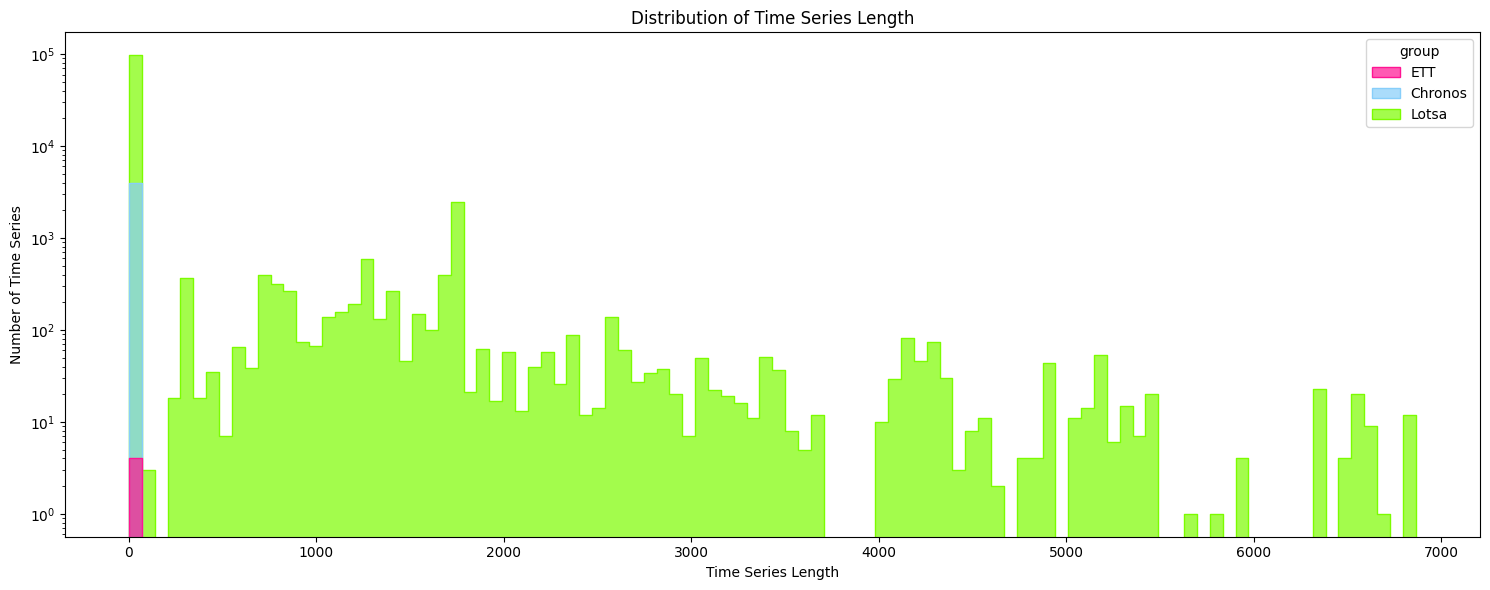

In [53]:
# === 2. Histogram: Time series length (ts_len) distribution ===
plt.figure()
sns.histplot(
    data=df, x="ts_len", hue="group", element="step", stat="count",
    common_norm=False, bins=100, palette=GROUP_PALETTE, alpha=0.7,
    hue_order=["ETT", "Chronos", "Lotsa"])
plt.title("Distribution of Time Series Length")
plt.xlabel("Time Series Length")
plt.ylabel("Number of Time Series")
plt.yscale("log")
plt.tight_layout()
plt.savefig("figures/plot_ts_len_distribution_final.png")
plt.show()

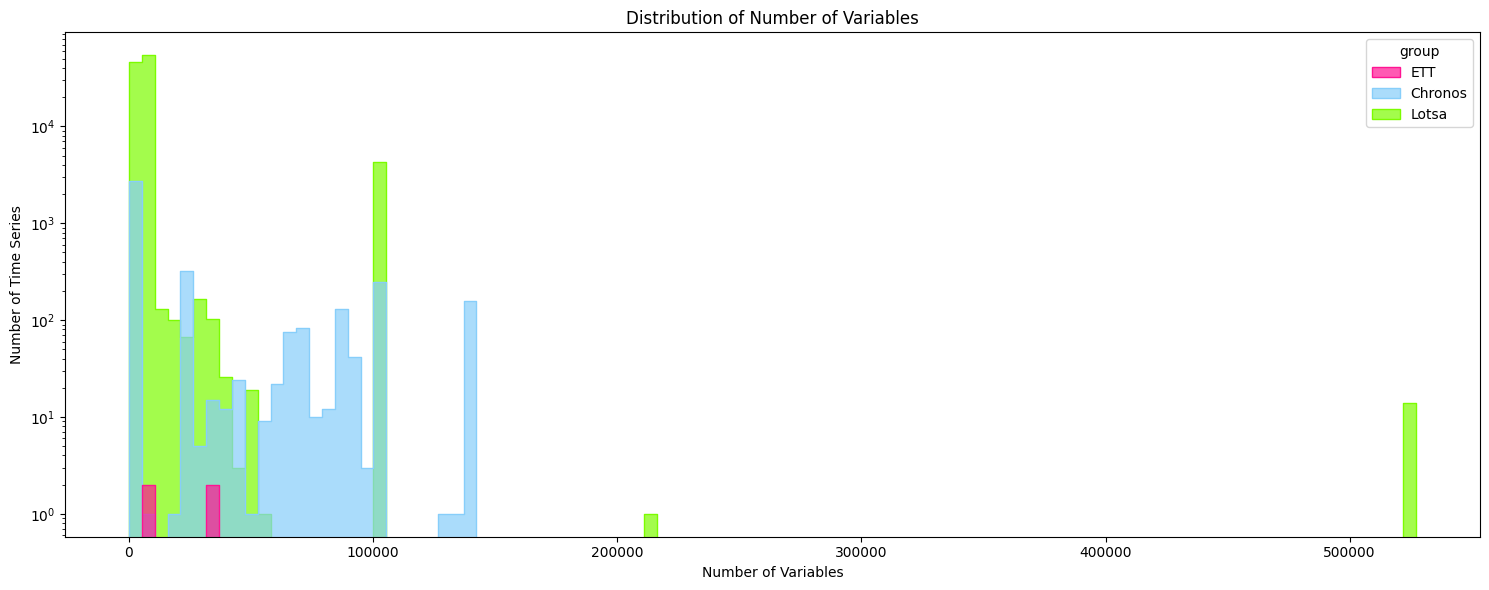

In [54]:
# === 3. Histogram: Number of variables per time series ===
plt.figure()
sns.histplot(
    data=df, x="num_variates", hue="group", element="step", stat="count",
    common_norm=False, bins=100, palette=GROUP_PALETTE, alpha=0.7,
    hue_order=["ETT", "Chronos", "Lotsa"])
plt.title("Distribution of Number of Variables")
plt.xlabel("Number of Variables")
plt.ylabel("Number of Time Series")
plt.yscale("log")
plt.tight_layout()
plt.savefig("figures/plot_num_variates_distribution_final.png")
plt.show()

In [55]:
FREQ_MAP = {
    "T": "1 min",
    "5T": "5 min",
    "10T": "10 min",
    "15T": "15 min",
    "30T": "30 min",
    "H": "1 hour",
    "1H": "1 hour",
    "6H": "6 hours",
    "D": "daily",
    "1D": "daily",
    "W": "weekly",
    "1W": "weekly",
    "W-SUN": "weekly",
    "M": "monthly",
    "MS": "monthly",      # Month Start
    "Q-DEC": "quarterly", # Quarterly ending in December
    "A-DEC": "yearly",    # Annual frequency ending in December
}

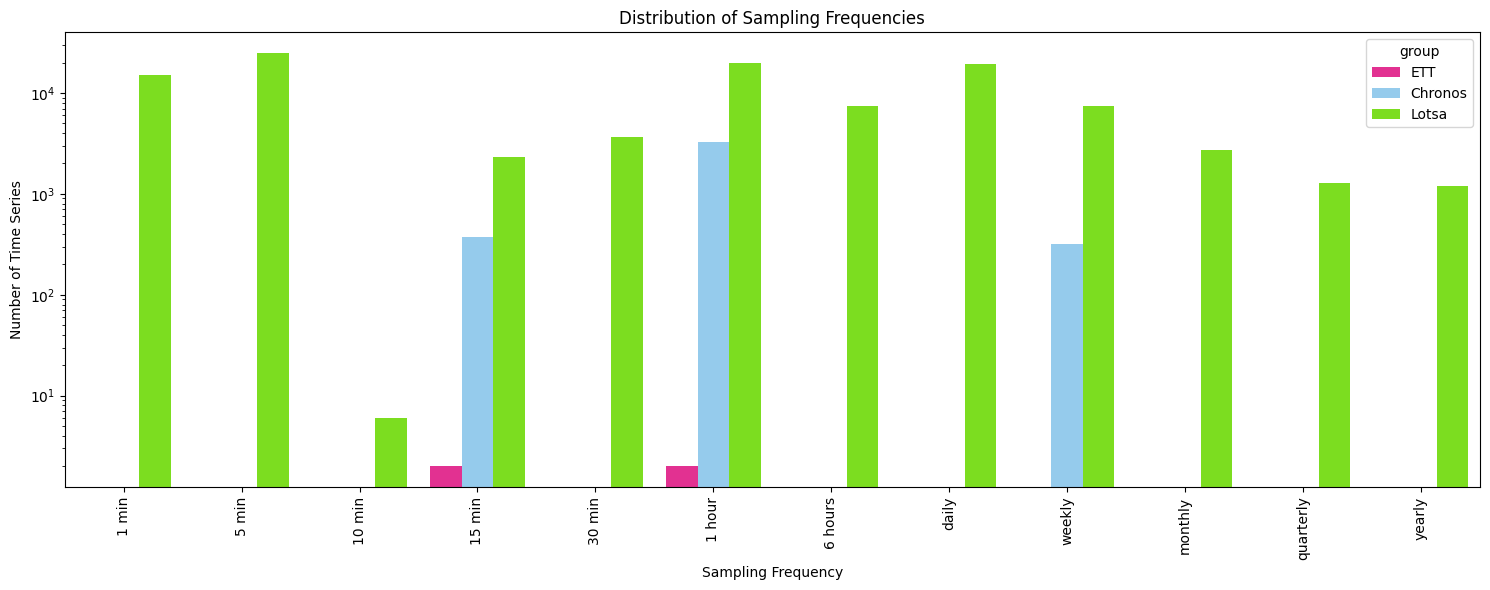

In [56]:
# === 4. Barplot: Frequency distribution per dataset group ===

# Map raw frequencies to human-readable labels
df["freq_label"] = df["freq"].map(FREQ_MAP).fillna("other")

# Order of the frequencies for plotting
FREQ_ORDER = [
    "1 min", "5 min", "10 min", "15 min", "30 min",
    "1 hour", "6 hours",
    "daily", "weekly", "monthly", "quarterly", "yearly"
]

# Plot the frequency distribution grouped by dataset group
plt.figure()
sns.countplot(
    data=df, x="freq_label", hue="group",
    order=FREQ_ORDER, palette=GROUP_PALETTE,
    hue_order=["ETT", "Chronos", "Lotsa"])
plt.title("Distribution of Sampling Frequencies")
plt.xlabel("Sampling Frequency")
plt.ylabel("Number of Time Series")
plt.xticks(rotation=90)
plt.yscale("log")
plt.tight_layout()
plt.savefig("figures/plot_freq_distribution_final.png")
plt.show()

### Final splitted dataset

In [57]:
# Load the dataset info CSV
df = pd.read_csv("results/dataset_splitted_train_val_info.csv", index_col=0)

In [58]:
GROUP_PALETTE = {
    "train": "lightskyblue",
    "val": "deeppink",
}

In [59]:
# Compute statistics
pivot_table = df.groupby("split").agg({
    "ts_len": ["mean", "std", "min", "max"],
    "num_variates": ["mean", "std", "min", "max", "count"],

})

# Rename columns for clarity
pivot_table.columns = ['_'.join(col).strip() for col in pivot_table.columns.values]
pivot_table = pivot_table.rename(columns={"num_variates_count": "num_series"})

# Round for better display
pivot_table = pivot_table.round(4)

pivot_table

,ts_len_mean,ts_len_std,ts_len_min,ts_len_max,num_variates_mean,num_variates_std,num_variates_min,num_variates_max,num_series
split,,,,,,,,,
train,124.5765,530.0581,1,6863,9014.4037,22262.0692,2,527040,87234
val,126.4039,530.6010,1,6863,8989.6485,22044.6399,2,527040,21744


C:\Users\giuli\AppData\Local\Temp\ipykernel_6768\2131169305.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="split", palette=GROUP_PALETTE)


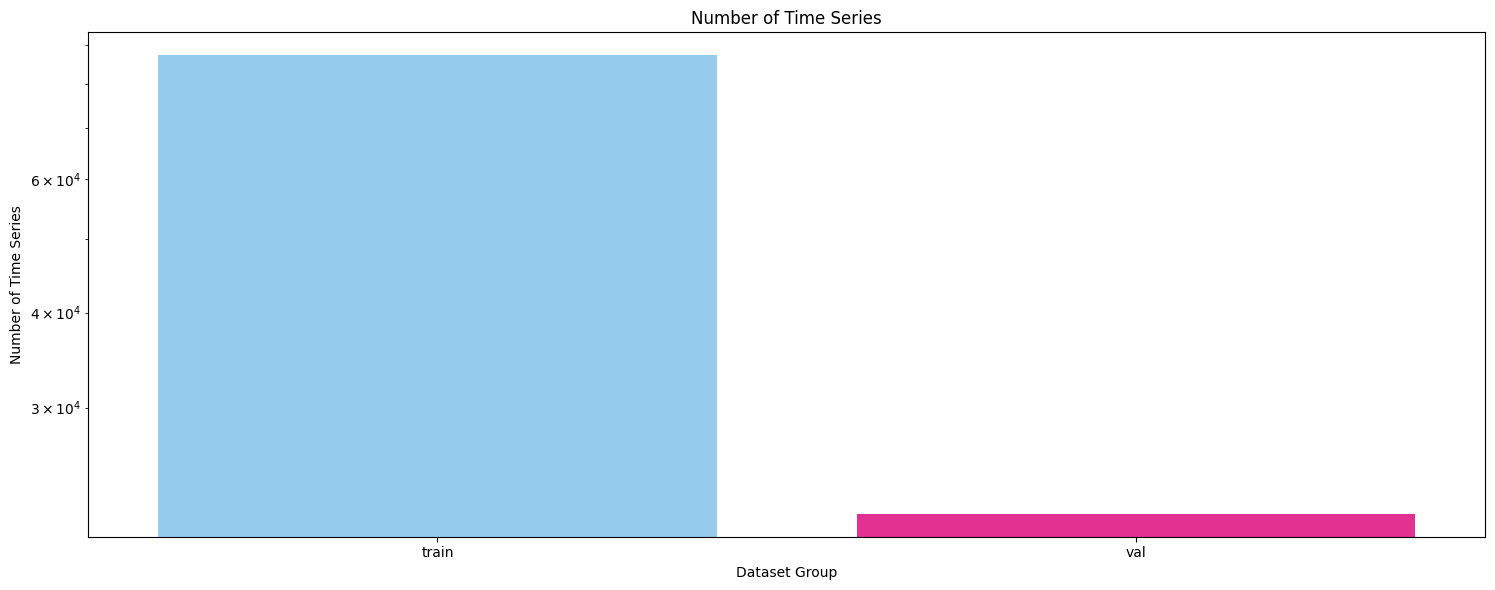

In [60]:
# === 1. Barplot: Number of time series per dataset group ===
plt.figure()
sns.countplot(data=df, x="split", palette=GROUP_PALETTE)
plt.title("Number of Time Series")
plt.xlabel("Dataset Group")
plt.ylabel("Number of Time Series")
plt.tight_layout()
plt.yscale("log")
plt.savefig("figures/plot_num_series_per_splitted_dataset.png")
plt.show()

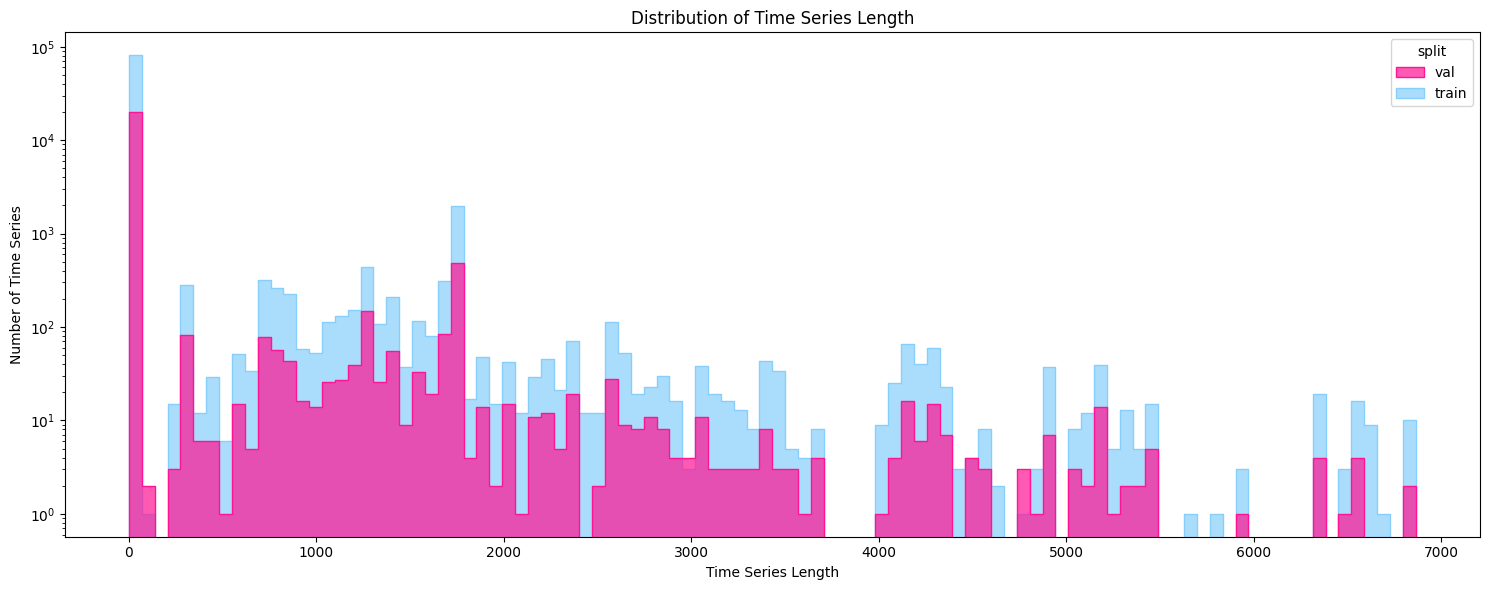

In [61]:
# === 2. Histogram: Time series length (ts_len) distribution ===
plt.figure()
sns.histplot(
    data=df, x="ts_len", hue="split", element="step", stat="count",
    common_norm=False, bins=100, palette=GROUP_PALETTE, alpha=0.7,
    hue_order=["val", "train"])
plt.title("Distribution of Time Series Length")
plt.xlabel("Time Series Length")
plt.ylabel("Number of Time Series")
plt.yscale("log")
plt.tight_layout()
plt.savefig("figures/plot_ts_len_splitted_distribution.png")
plt.show()

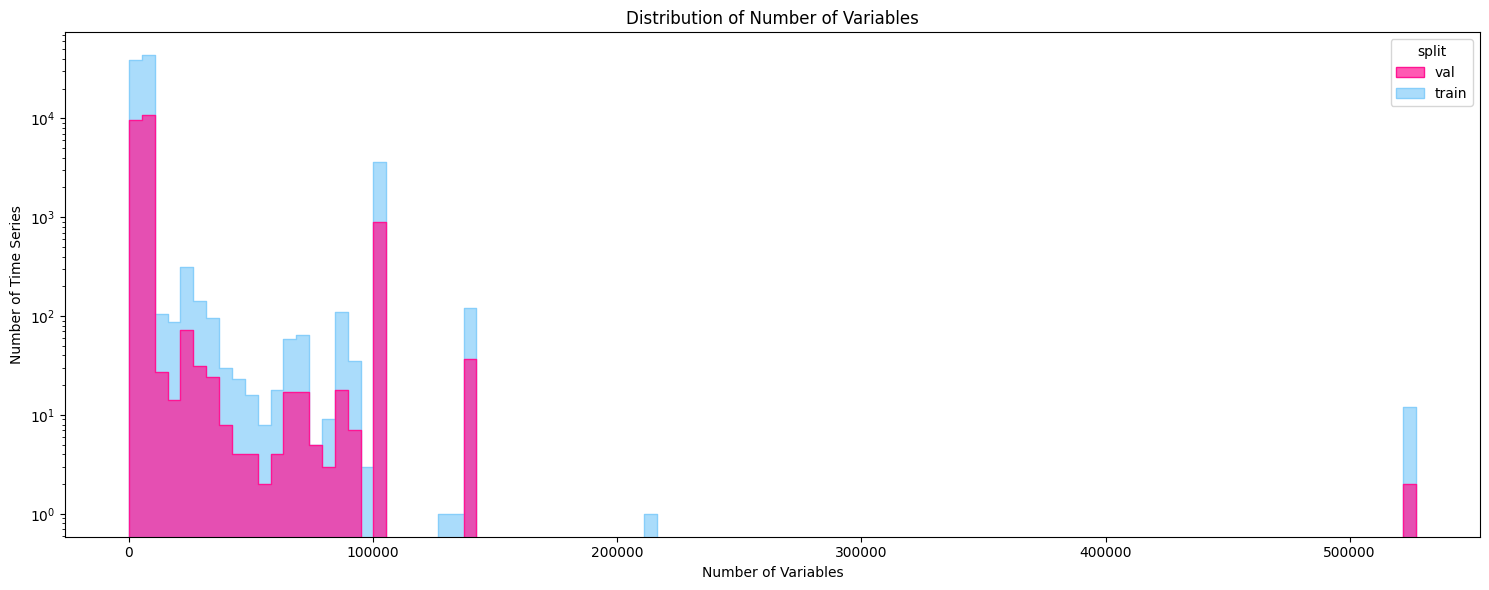

In [62]:
# === 3. Histogram: Number of variables per time series ===
plt.figure()
sns.histplot(
    data=df, x="num_variates", hue="split", element="step", stat="count",
    common_norm=False, bins=100, palette=GROUP_PALETTE, alpha=0.7,
    hue_order=["val", "train"])
plt.title("Distribution of Number of Variables")
plt.xlabel("Number of Variables")
plt.ylabel("Number of Time Series")
plt.yscale("log")
plt.tight_layout()
plt.savefig("figures/plot_num_variates_splitted_distribution.png")
plt.show()